# Headway Analysis on train arrival time
  
By Bohan

### Questions:
1. How important is the timint column?
2. What will be the consequences if we do not use it?

### Conclusions:
1. The distribution of data among three subwaylines is different, where SHEP line tends to have longer headway.
   SHEP: ~5min; YUS and BD: 3-4min
2. Headway over 125min has the potential for identify/remove mislabeled rows.
3. ~2.37% of rows have zero headway_time. By including timint in calculation, this precentage can drop to 0.202%.
4. Even though, the mean and median between headway with and without timint are comparable. Mann-Whitney rank test shows that they are from two different distributions.

### The goal of this analysis is to understand our data better, help future predictive modeling and unwanted data removal

### Input:
#### September 2019 data was processed by Data_Cleaning.py in the same file.
#### - It does not include any 'Delayed' message with timint==0 rows.
#### - It has already corrected labels of some rows but not all of them.

In [1]:
import numpy as np;  # useful for many scientific computing in Python
import pandas as pd; # primary data structure library
import scipy.stats; # for statistical tests
import datetime; # datetime data

# data from 201909 were used
# it was cleaned by running Data_Cleaning.py
df = pd.read_csv('merged_2019_09.csv'); # import file
df.head()

,Unnamed: 0,requestid,id,station_char,subwayline,timint,traindirection,trainid,train_message,train_dest,stationid,lineid,create_date,pollid,request_date,date,time
0,0,1542848,32918535973,WAR,BD,0.610891,East,1,Arriving,Westbound<br/> To Kipling,62,2,2019-09-03 09:21:42,29436,2019-09-03 09:21:40.820864-04:00,2019-09-03,09:21:40.820864
1,1,1542849,32918535978,KEN,BD,5.943837,East,1,Arriving,Westbound<br/> To Kipling,63,2,2019-09-03 09:21:42,29436,2019-09-03 09:21:40.821222-04:00,2019-09-03,09:21:40.821222
2,2,1523951,32918547750,WAR,BD,0.000000,East,1,AtStation,Westbound<br/> To Kipling,62,2,2019-09-03 09:22:44,29170,2019-09-03 09:22:40.460874-04:00,2019-09-03,09:22:40.460874
3,3,1523952,32918547755,KEN,BD,5.332946,East,1,Arriving,Westbound<br/> To Kipling,63,2,2019-09-03 09:22:44,29170,2019-09-03 09:22:40.461281-04:00,2019-09-03,09:22:40.461281
4,4,1582718,32918559768,KEN,BD,4.252532,East,1,Arriving,Westbound<br/> To Kipling,63,2,2019-09-03 09:23:42,29987,2019-09-03 09:23:40.825238-04:00,2019-09-03,09:23:40.825238


# Calculate Headway time 
### Step 1: Sort by 'stationid', 'traindirection', 'request_date', 'timint'  
Note: the timint == 0 rows with 'Delayed' message were already removed in previous cleaning.
### Step 2: Calculation:
#### 1) without timint: Headway  = request_date_row2 - request_date_row1.
#### 2) with timint: Headway2  = (request_date_row2 +timint_row2) - (request_date_row1 + timint_row1).
### Step 3: Remove negative and long (i.e. over 4 hr) headwaytime
#### NOTE: When station changes, the calculation was done between 2 stations, creating potential problem.  
#### Therefore, the dataframe was sorted by request_date. The above problematic rows are removed as we remove negative headways.


In [2]:
# drop rows with the same train at the same station on the same time
# NOTE: the timint == 0 rows with 'Delayed' message were already removed in previous cleaning
#ttc_2 = df.copy().sort_values(by=['stationid', 'traindirection', 'request_date', 'timint']);
ttc_2 = df.copy().sort_values(by=['requestid', 'request_date']);

# keep only one row per request and direction on each line
ttc_2.reset_index(drop=True, inplace=True);
ttc_2.drop_duplicates(subset=['requestid', 'traindirection', 'subwayline', 'stationid'],inplace=True);

# keep the earliest time if a train stayed at the same station for longer than one request
ttc_2.sort_values(by=['stationid', 'traindirection', 'request_date', 'timint'],inplace=True);
ttc_2.reset_index(drop=True, inplace=True);
# create a DataFrame where each row is shifted and last row comes on the top
ttc_c = ttc_2.iloc[:-1,:].copy();
ttc_c = pd.concat([ttc_2.tail(1), ttc_c], ignore_index=True);
ttc_2.reset_index(drop=True, inplace=True);
# drop rows where the same trainid apears back-to-back
ttc_2.drop(ttc_2[ttc_2.iloc[:,7] == ttc_c.iloc[:,7]].index, inplace=True);
ttc_2.reset_index(drop=True,inplace=True);

# Calculate headway
t1 = pd.to_datetime(ttc_2.iloc[1:,14]).reset_index(drop=True);
t2 =  pd.to_datetime(ttc_2.iloc[:-1,14]).reset_index(drop=True);

headway_time = t1 -t2;
headway_time2 = (t1+ pd.to_timedelta(ttc_2.iloc[1:,5],unit='s').reset_index(drop=True)
                ) - (t2 + pd.to_timedelta(ttc_2.iloc[:-1,5],unit='s')); 

ttc_3 = ttc_2.loc[1:, ['station_char', 'subwayline', 'timint', 'traindirection', 'trainid', 'train_message',
                       'stationid', 'lineid' ,'request_date', 'date', 'time']].copy();
ttc_3['headway_time'] = headway_time.astype('timedelta64[ns]');
ttc_3['headway_time2'] = headway_time2.astype('timedelta64[ns]');

ttc_3.head()

,station_char,subwayline,timint,traindirection,trainid,train_message,stationid,lineid,request_date,date,time,headway_time,headway_time2
1,SHW,YUS,5.546815,North,102,Arriving,1,1,2019-09-01 08:04:40.584475-04:00,2019-09-01,08:04:40.584475,00:05:00.202176,00:05:00.202176
2,SHW,YUS,5.546815,North,103,Arriving,1,1,2019-09-01 08:09:40.786651-04:00,2019-09-01,08:09:40.786651,00:04:59.812202,00:04:59.147498
3,SHW,YUS,4.882111,North,104,Arriving,1,1,2019-09-01 08:14:40.598853-04:00,2019-09-01,08:14:40.598853,00:05:59.695859,00:06:00.655062
4,SHW,YUS,5.841315,North,106,Arriving,1,1,2019-09-01 08:20:40.294712-04:00,2019-09-01,08:20:40.294712,00:05:00.247284,00:04:59.952784
5,SHW,YUS,5.546815,North,107,Arriving,1,1,2019-09-01 08:25:40.541996-04:00,2019-09-01,08:25:40.541996,00:04:59.997929,00:04:59.333225


In [3]:

ttc_3['headway_time'] = round(headway_time/pd.to_timedelta(1, unit='m'), 3);
ttc_3['headway_time2'] = round(headway_time2/pd.to_timedelta(1, unit='m'), 3);

ttc_3.head()

,station_char,subwayline,timint,traindirection,trainid,train_message,stationid,lineid,request_date,date,time,headway_time,headway_time2
1,SHW,YUS,5.546815,North,102,Arriving,1,1,2019-09-01 08:04:40.584475-04:00,2019-09-01,08:04:40.584475,5.003,5.003
2,SHW,YUS,5.546815,North,103,Arriving,1,1,2019-09-01 08:09:40.786651-04:00,2019-09-01,08:09:40.786651,4.997,4.986
3,SHW,YUS,4.882111,North,104,Arriving,1,1,2019-09-01 08:14:40.598853-04:00,2019-09-01,08:14:40.598853,5.995,6.011
4,SHW,YUS,5.841315,North,106,Arriving,1,1,2019-09-01 08:20:40.294712-04:00,2019-09-01,08:20:40.294712,5.004,4.999
5,SHW,YUS,5.546815,North,107,Arriving,1,1,2019-09-01 08:25:40.541996-04:00,2019-09-01,08:25:40.541996,5.000,4.989


In [4]:
# drop rows with negative headwaytime or long (i.e. over 4 hr) headwaytime
indD = ttc_3[ (ttc_3['headway_time'] < 0
              ) | (ttc_3['headway_time'] > 4*60)].index;
ttc_3.drop(indD, inplace=True);
ttc_3.head()

,station_char,subwayline,timint,traindirection,trainid,train_message,stationid,lineid,request_date,date,time,headway_time,headway_time2
1,SHW,YUS,5.546815,North,102,Arriving,1,1,2019-09-01 08:04:40.584475-04:00,2019-09-01,08:04:40.584475,5.003,5.003
2,SHW,YUS,5.546815,North,103,Arriving,1,1,2019-09-01 08:09:40.786651-04:00,2019-09-01,08:09:40.786651,4.997,4.986
3,SHW,YUS,4.882111,North,104,Arriving,1,1,2019-09-01 08:14:40.598853-04:00,2019-09-01,08:14:40.598853,5.995,6.011
4,SHW,YUS,5.841315,North,106,Arriving,1,1,2019-09-01 08:20:40.294712-04:00,2019-09-01,08:20:40.294712,5.004,4.999
5,SHW,YUS,5.546815,North,107,Arriving,1,1,2019-09-01 08:25:40.541996-04:00,2019-09-01,08:25:40.541996,5.000,4.989


### In the table below:
### 1. The row numbers (count column) are different between 3 lines (YUS>BD>SHEP)  
#### It makes sense because the numbers of stations are in the same order.
### 2. Even though only headway_time > 4hr (240min) were removed, the max values in dataset are much smaller.
#### It makes sense because we do not want to remove too much information.
### 3. In the graph, there are clusters around 140min and over. More analysis needs to be done on these.
### 4. The median headway time is higher for SHEP and those for BD and YUS are comparable.

In [5]:
ttc_3[['headway_time','headway_time2','subwayline']].groupby(['subwayline']).describe()

headway_time                                                \
                  count      mean       std  min    25%    50%    75%   
subwayline                                                              
BD             441759.0  4.044405  3.234190  0.0  2.001  3.384  5.016   
SHEP            50197.0  5.750889  4.698212  0.0  3.995  5.138  7.000   
YUS            562503.0  4.276652  3.679727  0.0  2.002  3.880  5.256   

                    headway_time2                                           \
                max         count      mean       std    min    25%    50%   
subwayline                                                                   
BD          141.271      441759.0  4.044937  3.211457 -0.298  2.028  3.375   
SHEP        199.855       50197.0  5.744318  4.695457 -0.179  4.000  5.173   
YUS         205.147      562503.0  4.276783  3.657466 -0.308  2.034  3.893   

                            
              75%      max  
subwayline                  
BD          5.062  141.175  
SHEP        6.960  199.855  
YUS         5.245  205.103

In [6]:
ttc_3[['headway_time','headway_time2','subwayline']].groupby(['subwayline']).median()

,headway_time,headway_time2
subwayline,,
BD,3.384,3.375
SHEP,5.138,5.173
YUS,3.880,3.893


array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000024B81AEDA88>,
      dtype=object)

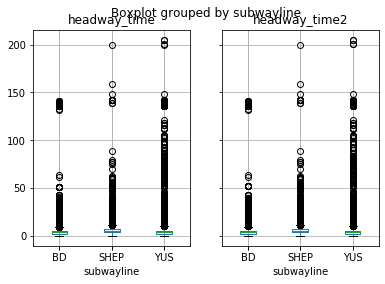

In [7]:
ttc_3[['headway_time','headway_time2','subwayline']].boxplot(column=['headway_time', 'headway_time2'], by='subwayline')

### What are the dots with headway above 125min?

In [8]:
ttc_3[ttc_3['headway_time'] > 125].sort_values(by=['request_date'])

,station_char,subwayline,timint,traindirection,trainid,train_message,stationid,lineid,request_date,date,time,headway_time,headway_time2
425739,KIP,BD,0.000000,East,214,Delayed,33,2,2019-09-01 06:00:40.737029-04:00,2019-09-01,06:00:40.737029,132.998,132.998
902524,KEN,BD,0.000000,East,203,Delayed,63,2,2019-09-01 06:00:40.758628-04:00,2019-09-01,06:00:40.758628,131.125,131.276
402645,YIE,YUS,0.000000,West,195,AtStation,30,1,2019-09-10 09:26:40.400714-04:00,2019-09-10,09:26:40.400714,148.002,148.002
981169,DML,SHEP,0.589933,West,464,Arriving,68,4,2019-09-13 18:14:03.923219-04:00,2019-09-13,18:14:03.923219,159.006,158.999
402655,YIE,SHEP,0.000000,West,552,AtStation,30,1,2019-09-18 12:04:04.663800-04:00,2019-09-18,12:04:04.663800,199.855,199.855
...,...,...,...,...,...,...,...,...,...,...,...,...,...
780094,PAP,BD,0.000000,East,232,AtStation,55,2,2019-09-18 19:05:04.210600-04:00,2019-09-18,19:05:04.210600,135.737,135.836
121289,BSP,YUS,11.551727,West,20,Arriving,9,1,2019-09-24 21:03:47.582359-04:00,2019-09-24,21:03:47.582359,205.147,205.103
134699,SGL,YUS,10.747664,West,20,Arriving,10,1,2019-09-24 21:03:55.571874-04:00,2019-09-24,21:03:55.571874,205.014,204.974
296230,YNG,YUS,8.833467,West,20,Arriving,22,1,2019-09-24 21:03:55.575567-04:00,2019-09-24,21:03:55.575567,200.014,200.052


In [9]:
print('# of unique trains affected: ', ttc_3[ttc_3['headway_time'] > 125]['trainid'].nunique());
print('# of total unique trains: ', ttc_3['trainid'].nunique());

# of unique trains affected:  85
# of total unique trains:  373


#### trainid == 20 is an example of mislabeling

In [10]:
ttc_3[(ttc_3['trainid'] == 20) & (ttc_3['date'] == '2019-09-24')].sort_values(by=['time']).iloc[-65:-50]

,station_char,subwayline,timint,traindirection,trainid,train_message,stationid,lineid,request_date,date,time,headway_time,headway_time2
713025,YNG,YUS,8.833467,West,20,Arriving,50,1,2019-09-24 21:03:47.580986-04:00,2019-09-24,21:03:47.580986,0.133,-0.014
684991,BAU,YUS,9.622290,West,20,Arriving,49,1,2019-09-24 21:03:47.581429-04:00,2019-09-24,21:03:47.581429,2.267,2.181
669856,SGL,YUS,10.747664,West,20,Arriving,48,1,2019-09-24 21:03:47.581883-04:00,2019-09-24,21:03:47.581883,0.133,-0.014
121289,BSP,YUS,11.551727,West,20,Arriving,9,1,2019-09-24 21:03:47.582359-04:00,2019-09-24,21:03:47.582359,205.147,205.103
134699,SGL,YUS,10.747664,West,20,Arriving,10,1,2019-09-24 21:03:55.571874-04:00,2019-09-24,21:03:55.571874,205.014,204.974
296230,YNG,YUS,8.833467,West,20,Arriving,22,1,2019-09-24 21:03:55.575567-04:00,2019-09-24,21:03:55.575567,200.014,200.052
805291,DON,YUS,1.295836,West,20,Arriving,56,1,2019-09-24 21:04:48.571404-04:00,2019-09-24,21:04:48.571404,0.000,0.025
821433,GWD,YUS,0.107244,West,20,Arriving,57,1,2019-09-24 21:04:56.571579-04:00,2019-09-24,21:04:56.571579,0.000,0.025
758505,BRD,YUS,4.217674,West,20,Arriving,53,1,2019-09-24 21:05:04.572070-04:00,2019-09-24,21:05:04.572070,0.983,0.913
743303,CFK,YUS,5.578138,West,20,Arriving,52,1,2019-09-24 21:05:04.572516-04:00,2019-09-24,21:05:04.572516,0.983,0.913


### Without outliers

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000024B85DDABC8>,
      dtype=object)

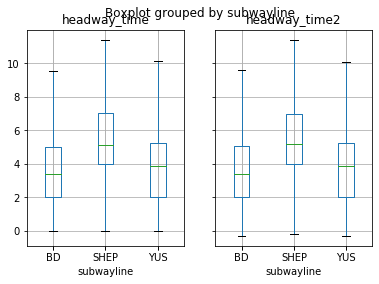

In [11]:
ttc_3[['headway_time','headway_time2','subwayline']].boxplot(column=['headway_time', 'headway_time2'], 
                                                             by='subwayline', showfliers=False)

### Is the difference among three subway lines statistically significant?

In [12]:
# perform Kruskal-Wallis H-test for headway_time
sta, pval = scipy.stats.mstats.kruskalwallis(ttc_3[ttc_3['subwayline'] == 'BD']['headway_time'].values,
                                ttc_3[ttc_3['subwayline'] == 'YUS']['headway_time'].values,
                               ttc_3[ttc_3['subwayline'] == 'SHEP']['headway_time'].values,);
print('p-value of headway_time = ', pval);


# perform Kruskal-Wallis H-test for headway_time
sta, pval = scipy.stats.mstats.kruskalwallis(ttc_3[ttc_3['subwayline'] == 'BD']['headway_time2'].values,
                                ttc_3[ttc_3['subwayline'] == 'YUS']['headway_time2'].values,
                               ttc_3[ttc_3['subwayline'] == 'SHEP']['headway_time2'].values,);
print('p-value of headway_time2 = ', pval);

p-value of headway_time =  0.0
p-value of headway_time2 =  0.0


#### According to Kruskal-Wallis test there is significant difference among them.
Post-hoc test needs to be performed to identify specific difference.

### Analysing rows with zero headway

In [13]:
print('# of zeros in headway_time = ', len(ttc_3[ttc_3['headway_time'] == 0].index))
print('# of zeros in headway_time2 = ', len(ttc_3[ttc_3['headway_time2'] == 0].index))

# of zeros in headway_time =  25014
# of zeros in headway_time2 =  1573


#### What is the median of all headway < 1min? 
#### Can we replace above zeros with this median?

In [14]:
print('-headway_time: ', np.median(ttc_3[ttc_3['headway_time'] < 1]['headway_time']))
print('-headway_time2: ', np.median(ttc_3[ttc_3['headway_time2'] < 1]['headway_time2']))

-headway_time:  0.744
-headway_time2:  0.759


### It means over half are above 0.7min, it does not capture very short headway characteristics.
### What about headyway < 0.7min?

In [15]:
print('-headway_time: ', np.median(ttc_3[ttc_3['headway_time'] < 0.7]['headway_time']))
print('-headway_time2: ', np.median(ttc_3[ttc_3['headway_time2'] < 0.7]['headway_time2']))

-headway_time:  0.0
-headway_time2:  0.069


#### The headway_time median goes to 0, meaning there is a huge gap between zeros and non-zeros
#### This gap is smaller for headway_time2 because the timint fills in for the gap

### Analysing difference between headway with and without timint
#### As shown below, there is significant difference (p<0.01) between two headway times by Mann-Whitney rank test even after only counting positive headways. The main reason is because the median is higher without timint in the caculation

In [16]:
print('with all data');
sta, pval = scipy.stats.mannwhitneyu(ttc_3['headway_time'].values, ttc_3['headway_time2'].values);
print('p-value = ', pval);


# find length before removing zeros and negatives
print('length of headway_time = ', len(ttc_3['headway_time']) );
print('length of headway_time2 = ', len(ttc_3['headway_time2']) );

# select only positive headway
h1 = ttc_3[ttc_3['headway_time'] > 0]['headway_time'].values;
h2 = ttc_3[ttc_3['headway_time2'] > 0]['headway_time2'].values;

# find length
print('Only with positive rows');
print('length of headway_time = ', len(h1) );
print('length of headway_time2 = ', len(h2) );

# perform Mann-Whitney rank test
sta, pval = scipy.stats.mannwhitneyu(h1, h2);
print('p-value = ', pval);

print('median of headway_time = ', np.median(h1) )
print('median of headway_time2 = ', np.median(h2) )

with all data
p-value =  2.121924708698428e-27
length of headway_time =  1054460
length of headway_time2 =  1054460
Only with positive rows
length of headway_time =  1029445
length of headway_time2 =  1052330
p-value =  8.216658339816237e-64
median of headway_time =  3.991
median of headway_time2 =  3.877
